In [4]:
!pip install -q qiskit
!pip install -q qiskit-aer
!pip install -q pylatexenc

In [5]:
from qiskit.quantum_info import Operator, Statevector, DensityMatrix
from qiskit.circuit.library import IGate, HGate, DiagonalGate
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from random import randint
import numpy as np

In [6]:
# Construct Oracle Operators for 8 random target states
random= [randint(0,63) for i in range(8)]
print(random)
U_list= []

for i in random:
    diagonal_list= [2*(j!=i)-1 for j in range(64)] # -1 if j==i, 1 otherwise
    d= DiagonalGate(diagonal_list)
    U_list.append(Operator(d)) # add the diagonal operator to the list

[54, 0, 57, 41, 18, 35, 52, 2]


In [7]:
# Construct the Diffuser Operator
H= Operator(HGate())
I= Operator(IGate())
H_6= H
I_6= I

# Tensor the Operators to expand them to 6 qubits
for i in range(5):
    H_6= H_6^H
    I_6= I_6^I

Psi= Statevector.from_label('000000')
Density_Operator= Operator(DensityMatrix(Psi.evolve(H_6)))
Diffuser= Operator(2*Density_Operator- (I_6))

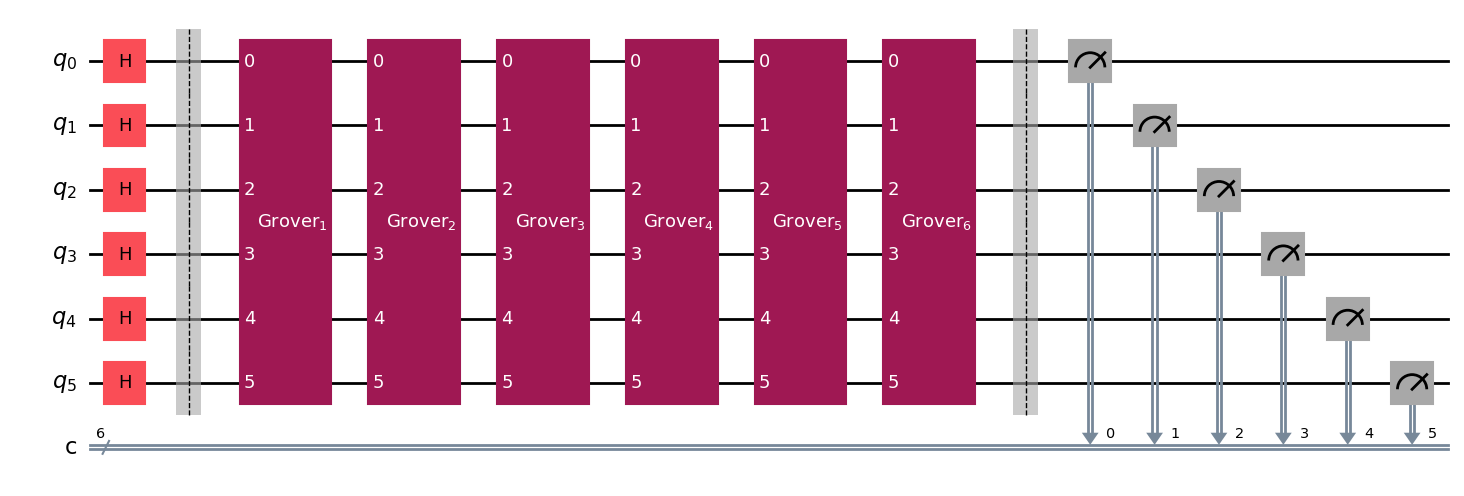

In [8]:
# Define a function to implement the Grover's Algorithm
def circuit(U):
    circuit= QuantumCircuit(6, 6)
    circuit.h(range(6)) # create a uniform superposition
    circuit.barrier()

    r= int(np.floor((np.pi/4)*np.sqrt(2**6))) # calculate the optimal number of iterations
    T= U.compose(Diffuser)

    for i in range(r):
        circuit.unitary(T.to_instruction(), range(6), f"Grover$_{i+1}$")

    circuit.barrier()

    circuit.measure(range(6), range(6))

    return circuit

display(circuit(I_6).draw(output="mpl")) # dummy circuit for visualisation

In [9]:
# Determine the Target States for each Query
outcomes= []

for U in U_list:
    result= AerSimulator().run(circuit(U), shots= 1).result()
    outcome= list(result.get_counts().keys())[0]
    outcomes.append(int(outcome, 2))

for i in range(8):
    print(f"Query {i+1}: The Target input is- {outcomes[i]}")

Query 1: The Target input is- 54
Query 2: The Target input is- 0
Query 3: The Target input is- 57
Query 4: The Target input is- 41
Query 5: The Target input is- 18
Query 6: The Target input is- 35
Query 7: The Target input is- 52
Query 8: The Target input is- 2
